# Robustness Exploration for Image Segmentation

This notebook evaluates robustness of segmentation models using the required 8 perturbations. We'll create perturbed test sets, apply them to our best model, and visualize the results.

## 1. Setup and Imports

In [1]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 8)


project_root = os.path.abspath(os.path.join(os.path.dirname('__file__'), '..'))
sys.path.append(project_root)

# Import our robustness evaluation module
from src.robustness_evaluation import (
    PerturbedPetDataset, 
    evaluate_model_on_perturbations,
    save_example_perturbations, 
    plot_perturbation_results,
    visualize_predictions
)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Configuration

In [2]:
# Set paths
DATASET_ROOT = '../Dataset_augmented/'  # Path to augmented dataset
MODEL_PATH = '../notebooks/models/unet_v7_unaugmented_dataset/unet_pet_segmentation_best.pt' # Path to best model
OUTPUT_DIR = '../robustness_results/'

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Load Best Model

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

# Define the UNet architecture
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, features_start=32):
        super(UNet, self).__init__()
        
        # Encoder (Downsampling)
        self.encoder1 = DoubleConv(in_channels, features_start)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(features_start, features_start*2)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = DoubleConv(features_start*2, features_start*4)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = DoubleConv(features_start*4, features_start*8)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottom
        self.bottom = DoubleConv(features_start*8, features_start*16)
        
        # Decoder (Upsampling)
        self.upconv4 = nn.ConvTranspose2d(features_start*16, features_start*8, kernel_size=2, stride=2)
        self.decoder4 = DoubleConv(features_start*16, features_start*8)
        self.upconv3 = nn.ConvTranspose2d(features_start*8, features_start*4, kernel_size=2, stride=2)
        self.decoder3 = DoubleConv(features_start*8, features_start*4)
        self.upconv2 = nn.ConvTranspose2d(features_start*4, features_start*2, kernel_size=2, stride=2)
        self.decoder2 = DoubleConv(features_start*4, features_start*2)
        self.upconv1 = nn.ConvTranspose2d(features_start*2, features_start, kernel_size=2, stride=2)
        self.decoder1 = DoubleConv(features_start*2, features_start)
        
        # Final Convolution
        self.final_conv = nn.Conv2d(features_start, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        
        # Bottom
        bottom = self.bottom(self.pool4(enc4))
        
        # Decoder with skip connections
        dec4 = self.upconv4(bottom)
        dec4 = torch.cat([dec4, enc4], dim=1)
        dec4 = self.decoder4(dec4)
        
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat([dec3, enc3], dim=1)
        dec3 = self.decoder3(dec3)
        
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat([dec2, enc2], dim=1)
        dec2 = self.decoder2(dec2)
        
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat([dec1, enc1], dim=1)
        dec1 = self.decoder1(dec1)
        
        return self.final_conv(dec1)

In [4]:
# Initialise model with the same parameters as during training
model = UNet(in_channels=3, out_channels=3, features_start=32)

# Load the checkpoint
checkpoint = torch.load(MODEL_PATH, map_location=device)

# The actual model state dictionary is under 'model_state_dict'
model.load_state_dict(checkpoint['model_state_dict'])

# Move to device and set to evaluation mode
model.to(device)
model.eval()

print("Model loaded successfully!")

print(f"Model was trained for {checkpoint['epoch']} epochs")
print(f"Final validation Dice score: {checkpoint['val_dice']}")
print(f"Final validation IoU: {checkpoint['val_iou']}")

Model loaded successfully!
Model was trained for 23 epochs
Final validation Dice score: 0.8635255694389343
Final validation IoU: 0.7676744858423868


C:\Users\dcb_r\AppData\Local\Temp\ipykernel_33816\1394805379.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


## 4. Generate Examples of Each Perturbation

Let's generate examples of each perturbation at different intensity levels. This will help us understand the visual impact of the perturbations and provide examples for the report.

In [5]:
# Directory to save example images
examples_dir = os.path.join(OUTPUT_DIR, 'examples')
os.makedirs(examples_dir, exist_ok=True)

# Save example images for all perturbations
print("Generating examples for each perturbation...")
save_example_perturbations(DATASET_ROOT, examples_dir)
print("Done generating examples!")

Generating examples for each perturbation...
Done generating examples!


Visualising the examples to understand how each perturbation affects the images at different intensity levels:

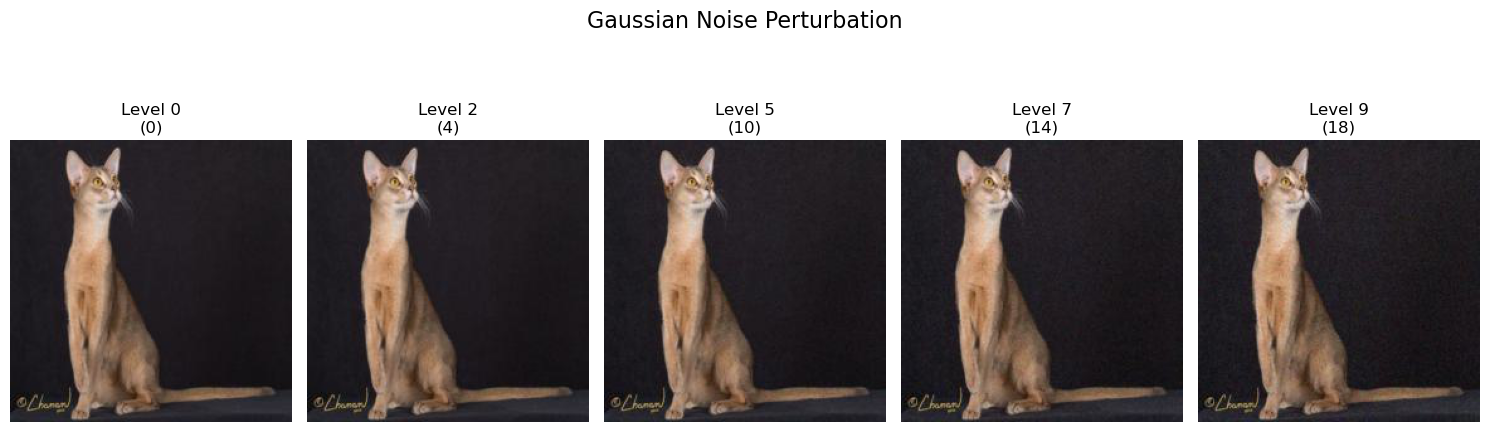

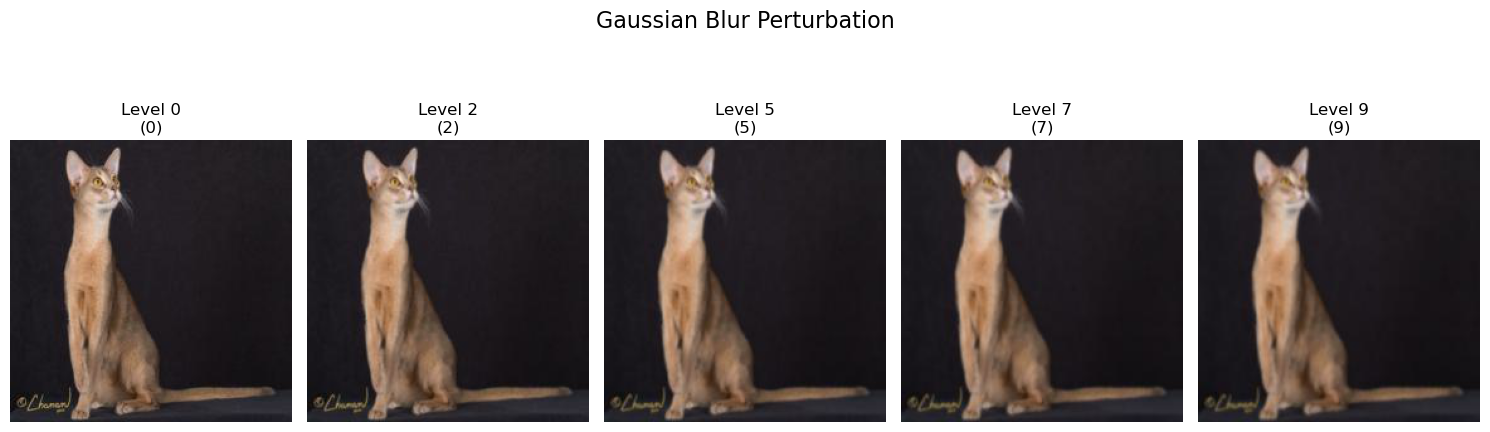

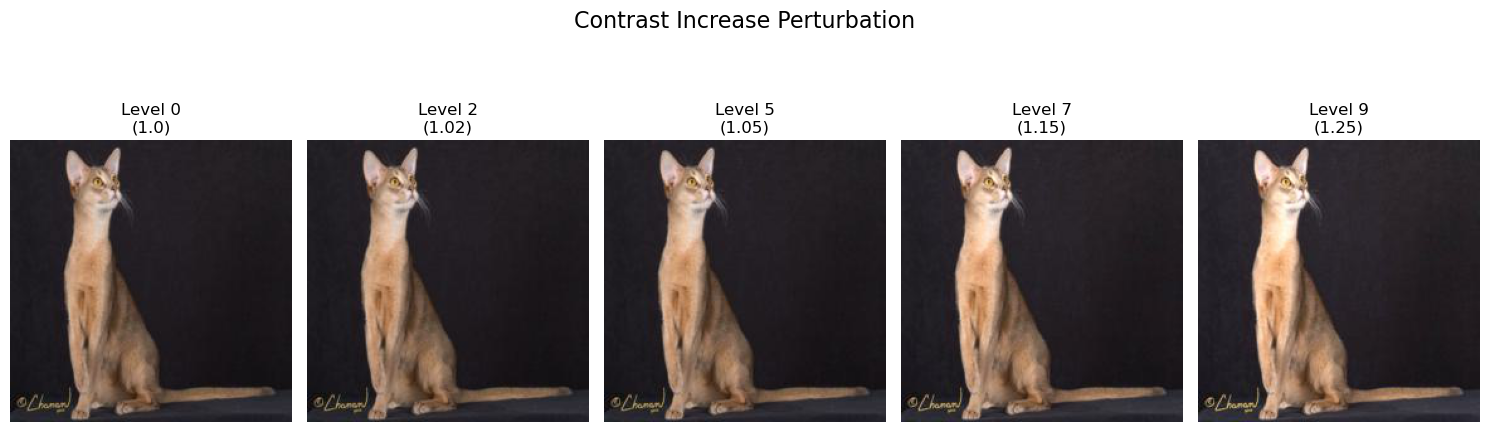

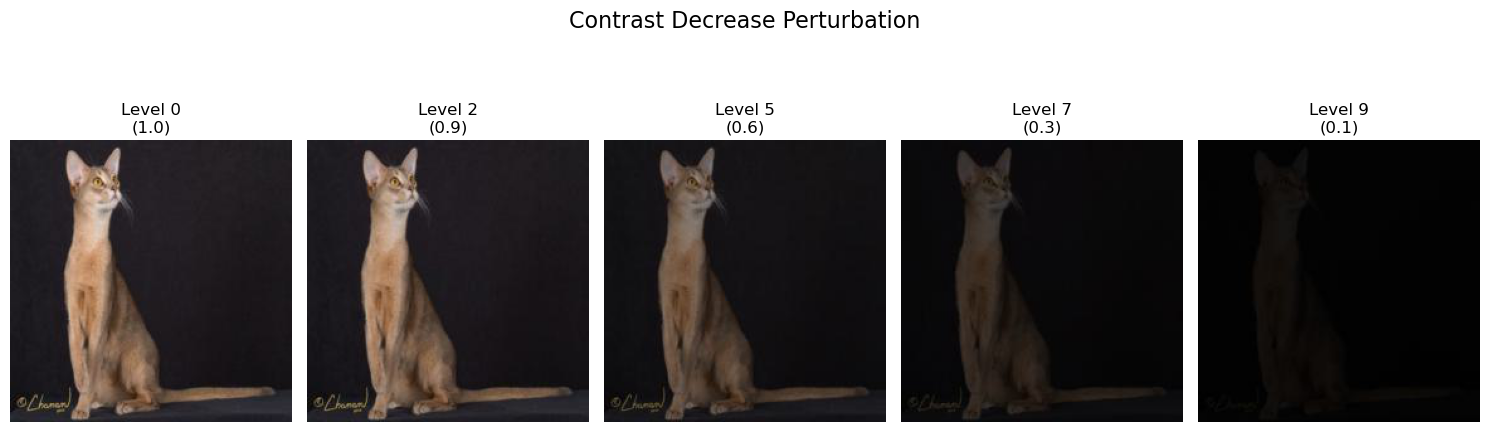

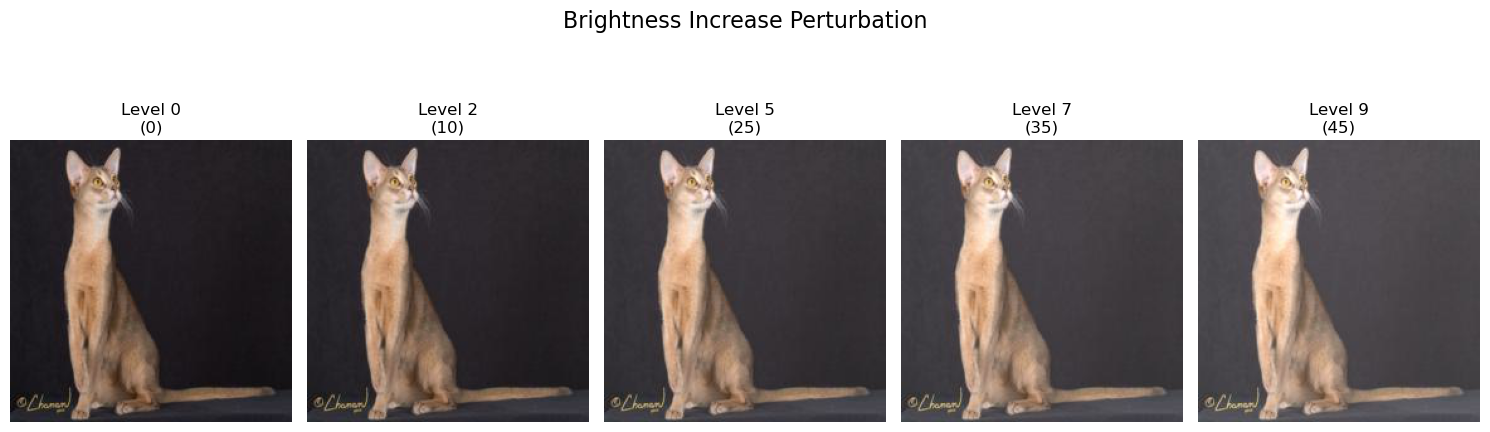

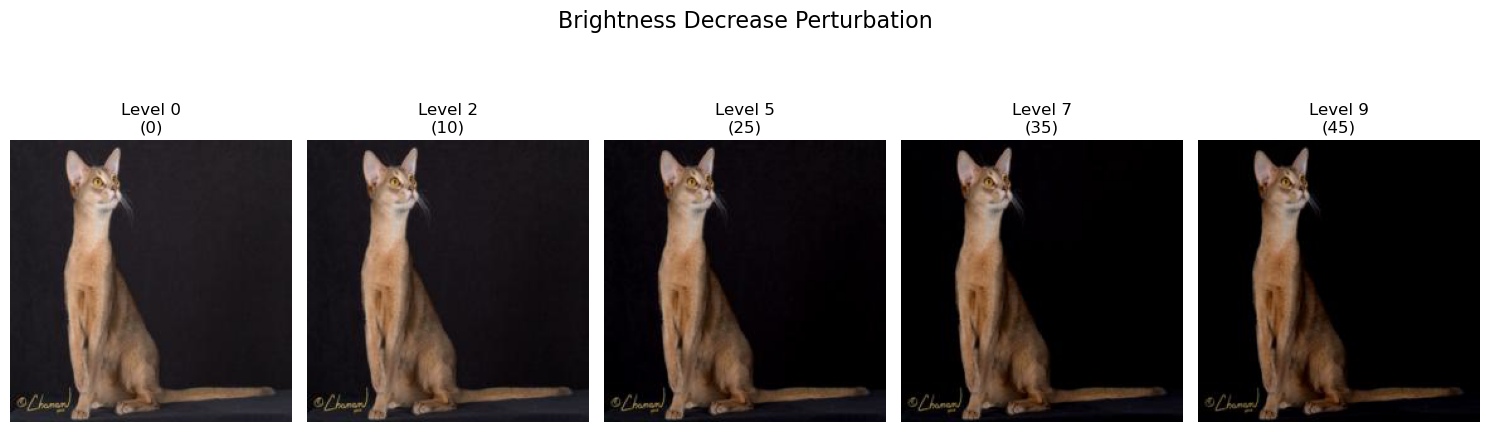

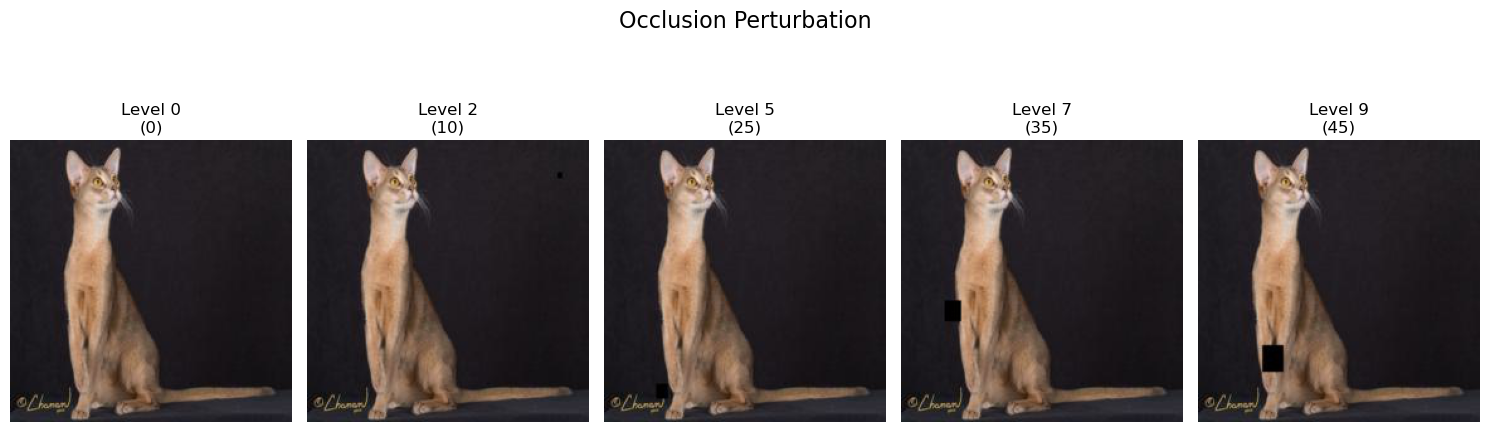

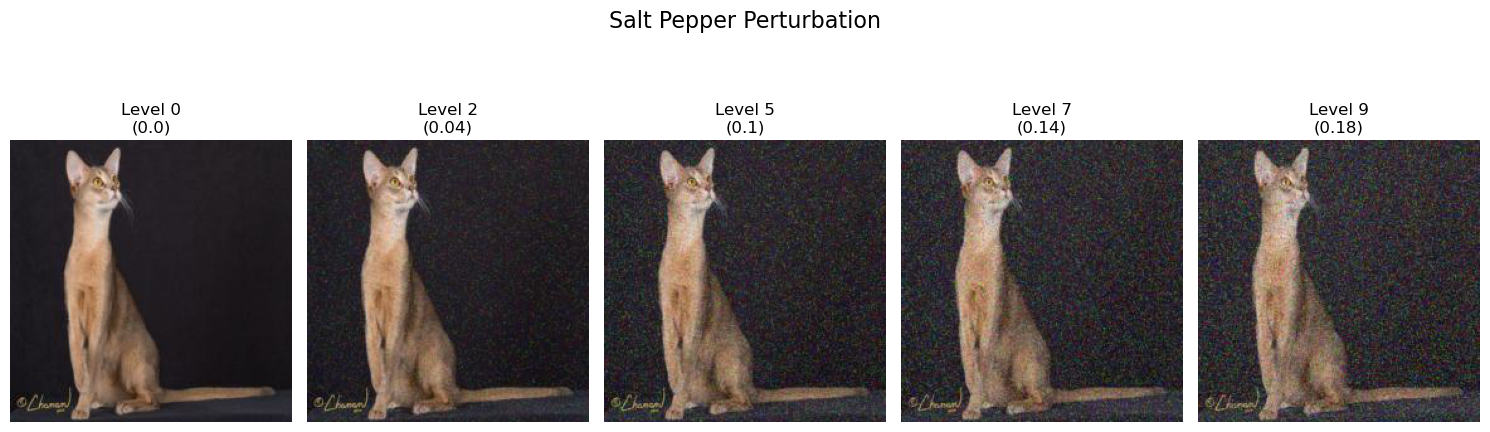

In [6]:
perturbation_types = [
    'gaussian_noise', 'gaussian_blur', 'contrast_increase', 'contrast_decrease',
    'brightness_increase', 'brightness_decrease', 'occlusion', 'salt_pepper'
]

# Get intensity values for axis labels
dummy_dataset = PerturbedPetDataset(None)
intensity_values = {p: dummy_dataset.intensity_values[p] for p in perturbation_types}

# Show examples of each perturbation at different levels
for perturbation in perturbation_types:
    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{perturbation.replace('_', ' ').title()} Perturbation", fontsize=16)
    
    # Show original and 4 levels of perturbation
    levels = [0, 2, 5, 7, 9]  # Original + 4 intensity levels
    
    for i, level in enumerate(levels):
        img_path = os.path.join(examples_dir, perturbation, f"level_{level}.jpg")
        if os.path.exists(img_path):
            img = Image.open(img_path)
            
            ax = plt.subplot(1, 5, i+1)
            plt.imshow(img)
            plt.title(f"Level {level}\n({intensity_values[perturbation][level]})", fontsize=12)
            plt.axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(os.path.join(OUTPUT_DIR, f"{perturbation}_examples.png"), dpi=300)
    plt.show()

## 5. Evaluate Model on All Perturbations

Now we'll evaluate our model's performance on each perturbation at all intensity levels.

In [7]:
# Evaluate model on all perturbations
print("Evaluating model on all perturbations.")
results = evaluate_model_on_perturbations(
    model, DATASET_ROOT, device, batch_size=8
)

# Save the results for later use
np.save(os.path.join(OUTPUT_DIR, 'perturbation_results.npy'), results)
print("Evaluation complete. Results saved to", os.path.join(OUTPUT_DIR, 'perturbation_results.npy'))

Evaluating model on all perturbations.
Evaluating gaussian_noise...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.11it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [01:16<00:00,  6.05it/s]


  Level 1: Dice = 0.6159


Level 2: 100%|██████████| 464/464 [01:16<00:00,  6.07it/s]


  Level 2: Dice = 0.6157


Level 3: 100%|██████████| 464/464 [01:17<00:00,  6.02it/s]


  Level 3: Dice = 0.6152


Level 4: 100%|██████████| 464/464 [01:16<00:00,  6.10it/s]


  Level 4: Dice = 0.6143


Level 5: 100%|██████████| 464/464 [01:17<00:00,  5.99it/s]


  Level 5: Dice = 0.6131


Level 6: 100%|██████████| 464/464 [01:16<00:00,  6.05it/s]


  Level 6: Dice = 0.6127


Level 7: 100%|██████████| 464/464 [01:16<00:00,  6.05it/s]


  Level 7: Dice = 0.6091


Level 8: 100%|██████████| 464/464 [01:16<00:00,  6.06it/s]


  Level 8: Dice = 0.6075


Level 9: 100%|██████████| 464/464 [01:16<00:00,  6.04it/s]


  Level 9: Dice = 0.6046
Evaluating gaussian_blur...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.14it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [01:29<00:00,  5.21it/s]


  Level 1: Dice = 0.6134


Level 2: 100%|██████████| 464/464 [02:18<00:00,  3.35it/s]


  Level 2: Dice = 0.6089


Level 3: 100%|██████████| 464/464 [03:01<00:00,  2.55it/s]


  Level 3: Dice = 0.6041


Level 4: 100%|██████████| 464/464 [03:54<00:00,  1.98it/s]


  Level 4: Dice = 0.5986


Level 5: 100%|██████████| 464/464 [04:36<00:00,  1.68it/s]


  Level 5: Dice = 0.5937


Level 6: 100%|██████████| 464/464 [05:10<00:00,  1.50it/s]


  Level 6: Dice = 0.5889


Level 7: 100%|██████████| 464/464 [05:52<00:00,  1.32it/s]


  Level 7: Dice = 0.5840


Level 8: 100%|██████████| 464/464 [06:36<00:00,  1.17it/s]


  Level 8: Dice = 0.5793


Level 9: 100%|██████████| 464/464 [07:23<00:00,  1.05it/s]


  Level 9: Dice = 0.5743
Evaluating contrast_increase...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.39it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [00:35<00:00, 13.22it/s]


  Level 1: Dice = 0.6160


Level 2: 100%|██████████| 464/464 [00:35<00:00, 12.99it/s]


  Level 2: Dice = 0.6161


Level 3: 100%|██████████| 464/464 [00:35<00:00, 13.18it/s]


  Level 3: Dice = 0.6161


Level 4: 100%|██████████| 464/464 [00:35<00:00, 13.15it/s]


  Level 4: Dice = 0.6162


Level 5: 100%|██████████| 464/464 [00:35<00:00, 13.17it/s]


  Level 5: Dice = 0.6162


Level 6: 100%|██████████| 464/464 [00:35<00:00, 13.15it/s]


  Level 6: Dice = 0.6162


Level 7: 100%|██████████| 464/464 [00:35<00:00, 12.90it/s]


  Level 7: Dice = 0.6164


Level 8: 100%|██████████| 464/464 [00:35<00:00, 13.04it/s]


  Level 8: Dice = 0.6155


Level 9: 100%|██████████| 464/464 [00:35<00:00, 12.92it/s]


  Level 9: Dice = 0.6140
Evaluating contrast_decrease...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.42it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [00:35<00:00, 13.14it/s]


  Level 1: Dice = 0.6151


Level 2: 100%|██████████| 464/464 [00:35<00:00, 13.12it/s]


  Level 2: Dice = 0.6142


Level 3: 100%|██████████| 464/464 [00:35<00:00, 13.12it/s]


  Level 3: Dice = 0.6129


Level 4: 100%|██████████| 464/464 [00:35<00:00, 13.05it/s]


  Level 4: Dice = 0.6113


Level 5: 100%|██████████| 464/464 [00:35<00:00, 13.02it/s]


  Level 5: Dice = 0.5984


Level 6: 100%|██████████| 464/464 [00:35<00:00, 13.16it/s]


  Level 6: Dice = 0.5579


Level 7: 100%|██████████| 464/464 [00:35<00:00, 13.12it/s]


  Level 7: Dice = 0.5048


Level 8: 100%|██████████| 464/464 [00:35<00:00, 13.11it/s]


  Level 8: Dice = 0.4173


Level 9: 100%|██████████| 464/464 [00:35<00:00, 13.03it/s]


  Level 9: Dice = 0.3408
Evaluating brightness_increase...


Level 0: 100%|██████████| 464/464 [00:28<00:00, 16.38it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [00:33<00:00, 13.97it/s]


  Level 1: Dice = 0.6177


Level 2: 100%|██████████| 464/464 [00:33<00:00, 13.70it/s]


  Level 2: Dice = 0.6177


Level 3: 100%|██████████| 464/464 [00:33<00:00, 13.79it/s]


  Level 3: Dice = 0.6174


Level 4: 100%|██████████| 464/464 [00:33<00:00, 13.77it/s]


  Level 4: Dice = 0.6168


Level 5: 100%|██████████| 464/464 [00:33<00:00, 13.93it/s]


  Level 5: Dice = 0.6159


Level 6: 100%|██████████| 464/464 [00:35<00:00, 13.16it/s]


  Level 6: Dice = 0.6140


Level 7: 100%|██████████| 464/464 [00:35<00:00, 13.10it/s]


  Level 7: Dice = 0.6125


Level 8: 100%|██████████| 464/464 [00:35<00:00, 13.24it/s]


  Level 8: Dice = 0.6107


Level 9: 100%|██████████| 464/464 [00:34<00:00, 13.46it/s]


  Level 9: Dice = 0.6085
Evaluating brightness_decrease...


Level 0: 100%|██████████| 464/464 [00:29<00:00, 15.66it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [00:34<00:00, 13.36it/s]


  Level 1: Dice = 0.6153


Level 2: 100%|██████████| 464/464 [00:34<00:00, 13.41it/s]


  Level 2: Dice = 0.6142


Level 3: 100%|██████████| 464/464 [00:34<00:00, 13.35it/s]


  Level 3: Dice = 0.6128


Level 4: 100%|██████████| 464/464 [00:34<00:00, 13.46it/s]


  Level 4: Dice = 0.6107


Level 5: 100%|██████████| 464/464 [00:34<00:00, 13.31it/s]


  Level 5: Dice = 0.6081


Level 6: 100%|██████████| 464/464 [00:33<00:00, 13.78it/s]


  Level 6: Dice = 0.6048


Level 7: 100%|██████████| 464/464 [00:33<00:00, 13.84it/s]


  Level 7: Dice = 0.6009


Level 8: 100%|██████████| 464/464 [00:33<00:00, 13.96it/s]


  Level 8: Dice = 0.5965


Level 9: 100%|██████████| 464/464 [00:33<00:00, 13.92it/s]


  Level 9: Dice = 0.5913
Evaluating occlusion...


Level 0: 100%|██████████| 464/464 [00:27<00:00, 16.71it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [00:29<00:00, 15.83it/s]


  Level 1: Dice = 0.6159


Level 2: 100%|██████████| 464/464 [00:29<00:00, 15.84it/s]


  Level 2: Dice = 0.6159


Level 3: 100%|██████████| 464/464 [00:29<00:00, 15.80it/s]


  Level 3: Dice = 0.6157


Level 4: 100%|██████████| 464/464 [00:29<00:00, 15.94it/s]


  Level 4: Dice = 0.6159


Level 5: 100%|██████████| 464/464 [00:29<00:00, 15.58it/s]


  Level 5: Dice = 0.6143


Level 6: 100%|██████████| 464/464 [00:29<00:00, 15.90it/s]


  Level 6: Dice = 0.6137


Level 7: 100%|██████████| 464/464 [00:29<00:00, 15.51it/s]


  Level 7: Dice = 0.6123


Level 8: 100%|██████████| 464/464 [00:29<00:00, 15.93it/s]


  Level 8: Dice = 0.6107


Level 9: 100%|██████████| 464/464 [00:29<00:00, 15.90it/s]


  Level 9: Dice = 0.6090
Evaluating salt_pepper...


Level 0: 100%|██████████| 464/464 [00:29<00:00, 15.96it/s]


  Level 0: Dice = 0.6159


Level 1: 100%|██████████| 464/464 [01:13<00:00,  6.27it/s]


  Level 1: Dice = 0.5900


Level 2: 100%|██████████| 464/464 [01:13<00:00,  6.30it/s]


  Level 2: Dice = 0.5674


Level 3: 100%|██████████| 464/464 [01:16<00:00,  6.05it/s]


  Level 3: Dice = 0.5412


Level 4: 100%|██████████| 464/464 [01:16<00:00,  6.04it/s]


  Level 4: Dice = 0.5153


Level 5: 100%|██████████| 464/464 [01:16<00:00,  6.04it/s]


  Level 5: Dice = 0.4848


Level 6: 100%|██████████| 464/464 [01:20<00:00,  5.75it/s]


  Level 6: Dice = 0.4522


Level 7: 100%|██████████| 464/464 [01:19<00:00,  5.83it/s]


  Level 7: Dice = 0.4158


Level 8: 100%|██████████| 464/464 [01:19<00:00,  5.82it/s]


  Level 8: Dice = 0.3862


Level 9: 100%|██████████| 464/464 [01:19<00:00,  5.82it/s]

  Level 9: Dice = 0.3575
Evaluation complete. Results saved to ../robustness_results/perturbation_results.npy


## 6. Visualise Results for Each Perturbation

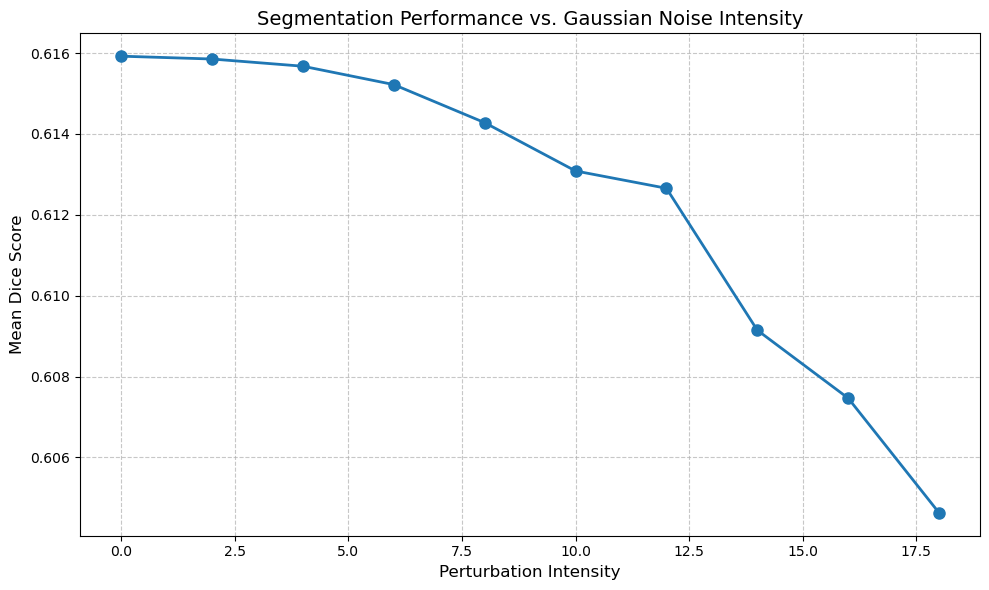

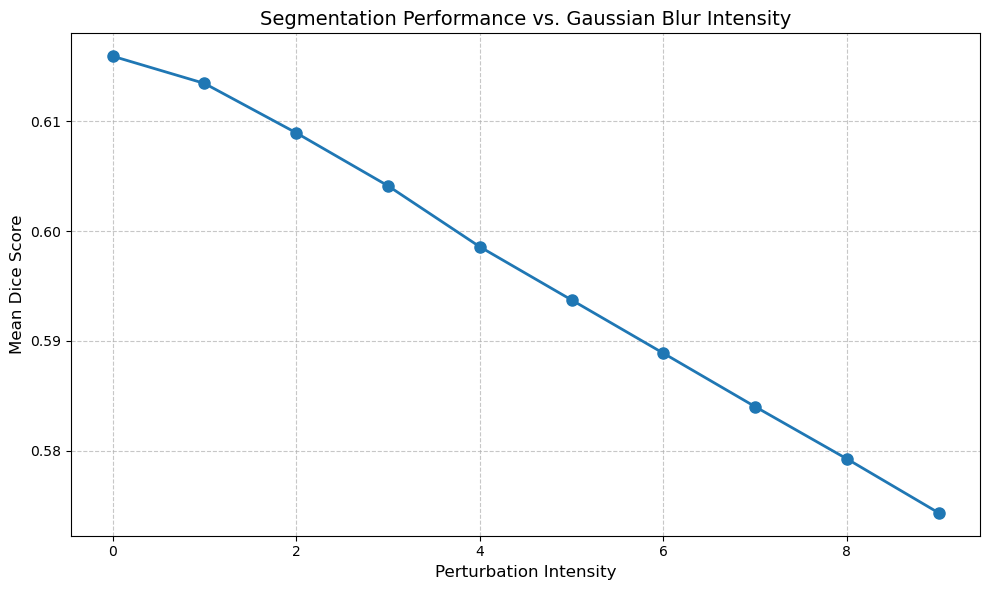

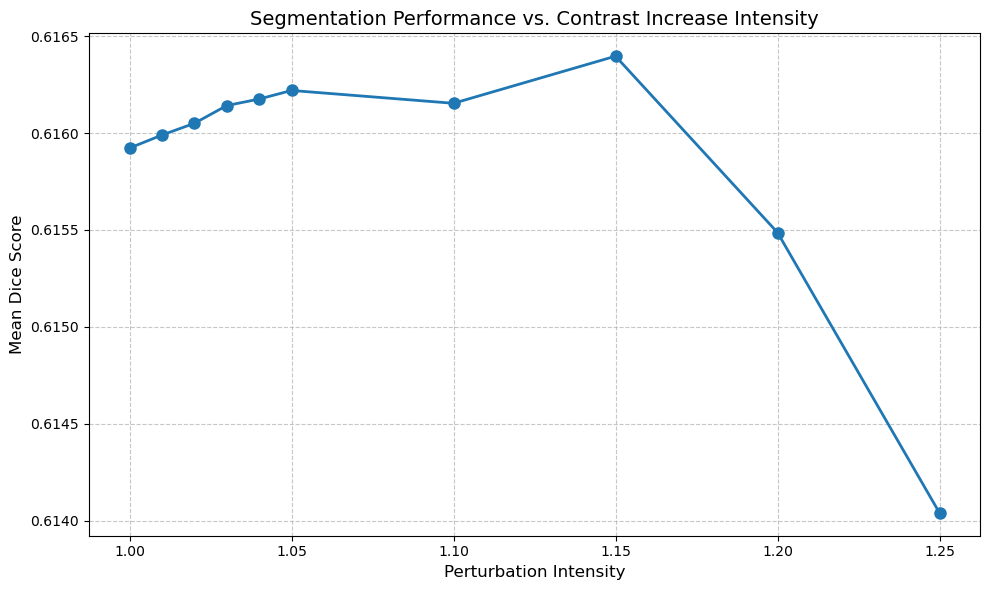

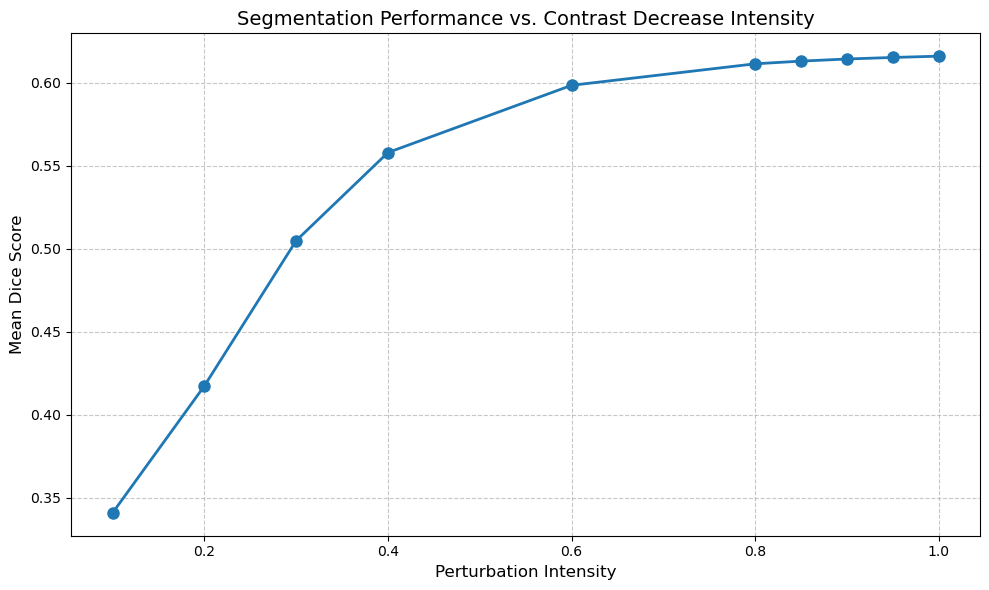

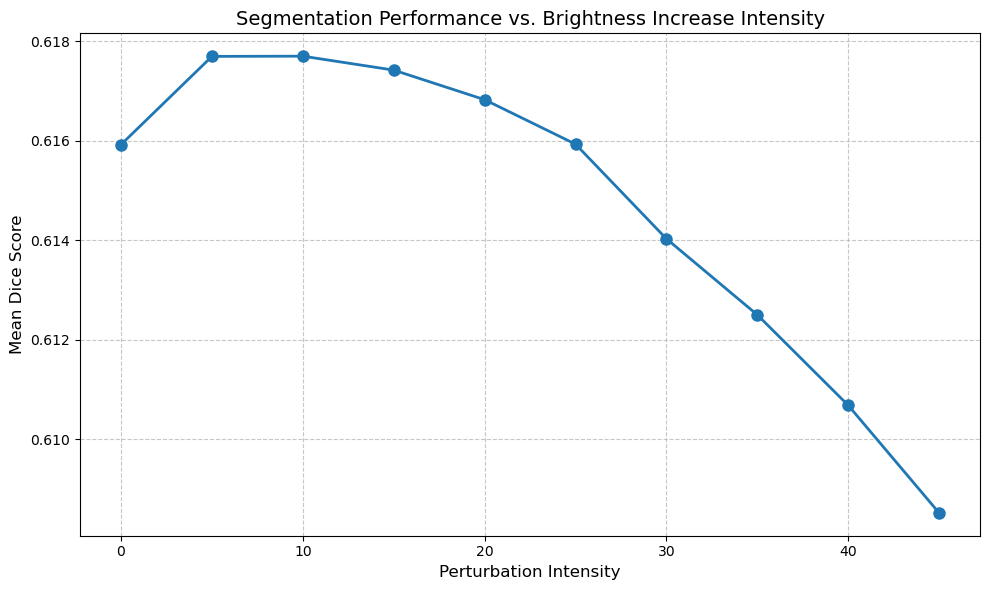

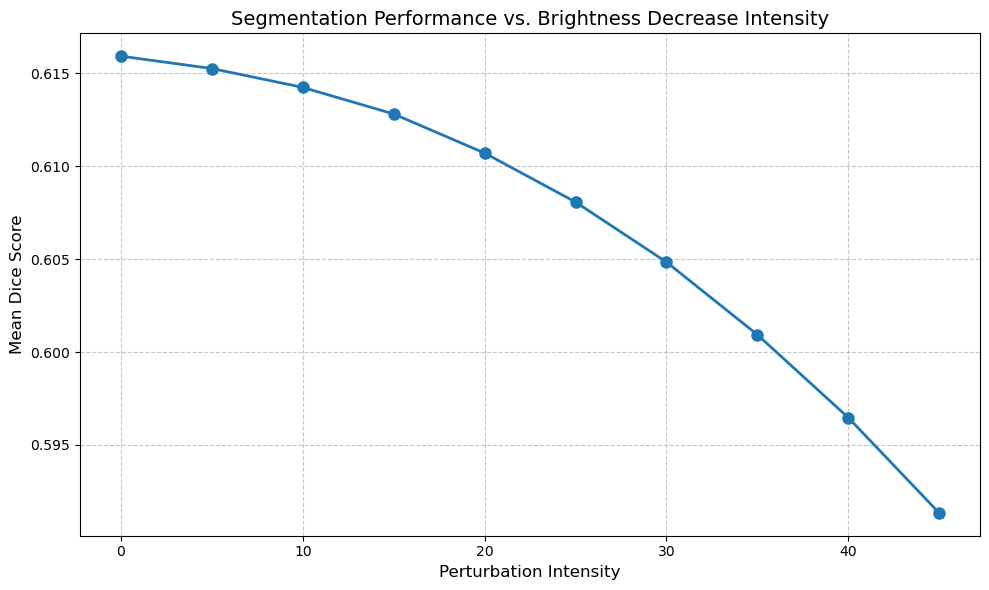

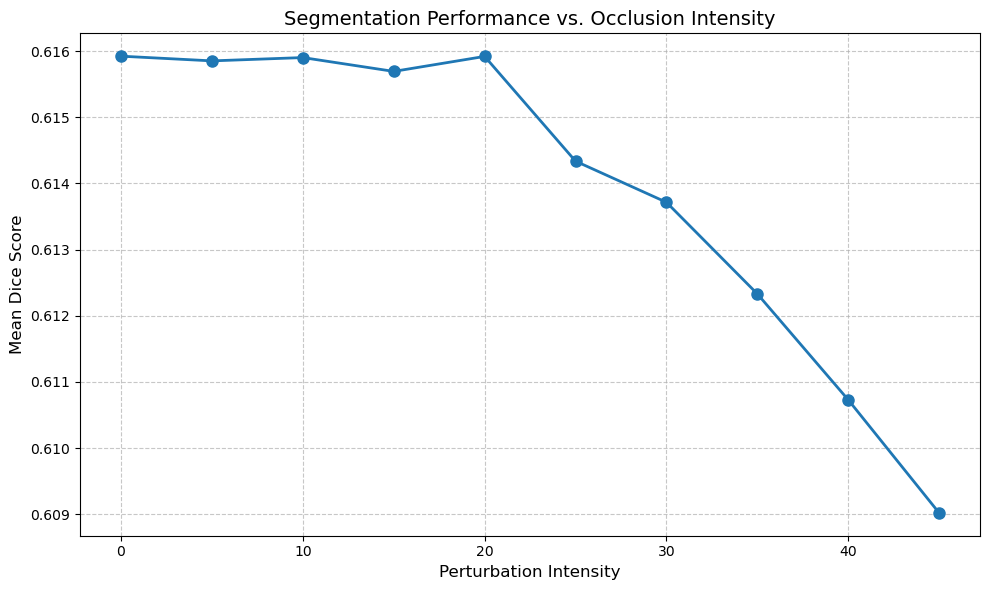

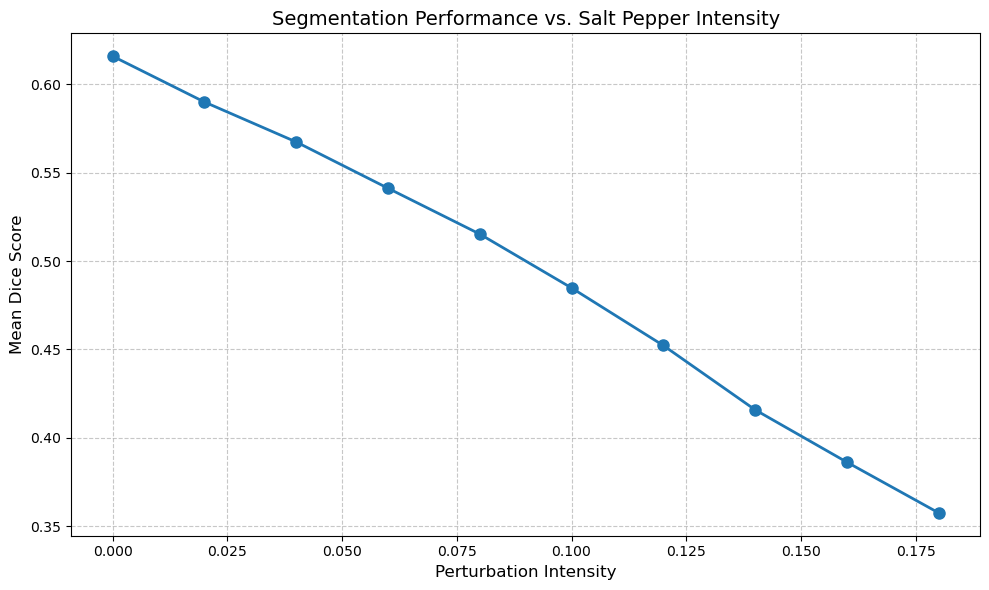

In [8]:
# Load results if we're running this cell separately
try:
    results = np.load(os.path.join(OUTPUT_DIR, 'perturbation_results.npy'), allow_pickle=True).item()
except:
    pass

# Create plots for each perturbation
plot_perturbation_results(results, OUTPUT_DIR)

# Display each perturbation plot
for perturbation in results.keys():
    plt.figure(figsize=(10, 6))
    
    # Get the intensity values for this perturbation
    intensity_values = dummy_dataset.intensity_values[perturbation]
    
    plt.plot(intensity_values, results[perturbation], 'o-', linewidth=2, markersize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.title(f"Segmentation Performance vs. {perturbation.replace('_', ' ').title()} Intensity", fontsize=14)
    plt.xlabel("Perturbation Intensity", fontsize=12)
    plt.ylabel("Mean Dice Score", fontsize=12)
    
    plt.tight_layout()
    plt.show()

## 7. Combined Visualisation

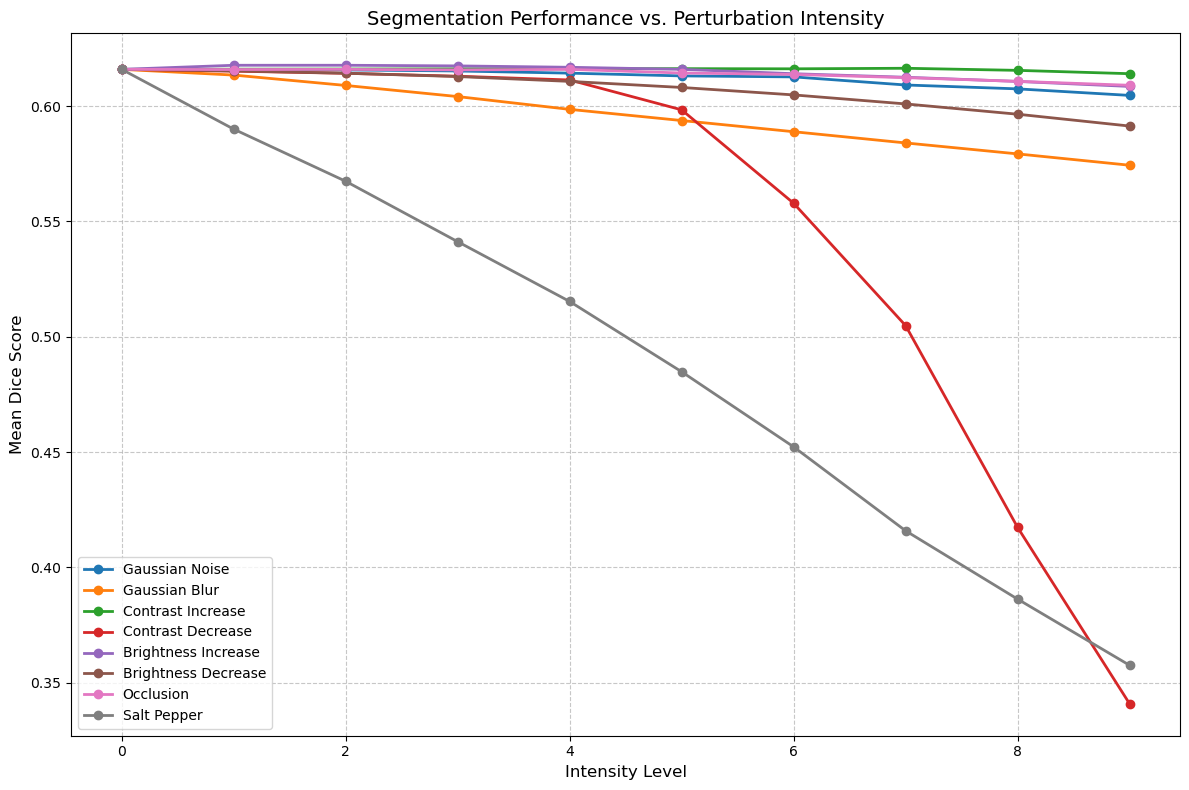

In [9]:
# Create a combined plot
plt.figure(figsize=(12, 8))

for perturbation, scores in results.items():
    # Use intensity level (0-9) for x-axis to make comparison easier
    intensity_level = list(range(len(scores)))
    
    plt.plot(intensity_level, scores, 'o-', linewidth=2, markersize=6, 
             label=perturbation.replace('_', ' ').title())

plt.grid(True, linestyle='--', alpha=0.7)
plt.title("Segmentation Performance vs. Perturbation Intensity", fontsize=14)
plt.xlabel("Intensity Level", fontsize=12)
plt.ylabel("Mean Dice Score", fontsize=12)
plt.legend(loc='best', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "combined_results.png"), dpi=300)
plt.show()

## 8. Analyse Impact of Different Perturbations

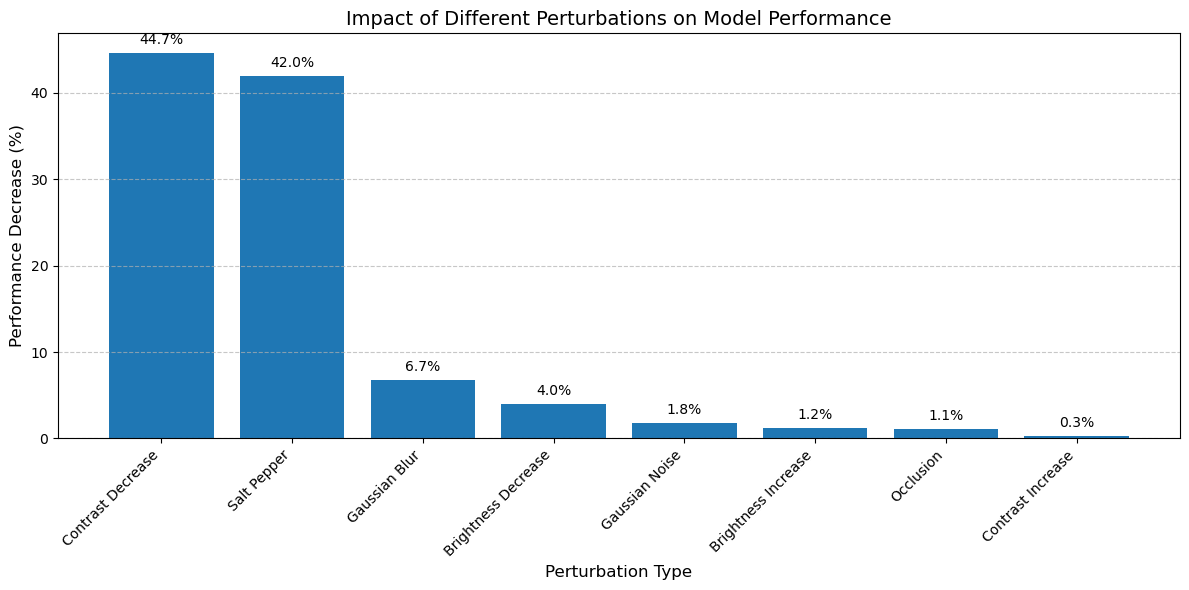

Ranking of perturbations by impact on model performance:
1. Contrast Decrease: 44.66% decrease in Dice score
2. Salt Pepper: 41.95% decrease in Dice score
3. Gaussian Blur: 6.75% decrease in Dice score
4. Brightness Decrease: 3.99% decrease in Dice score
5. Gaussian Noise: 1.83% decrease in Dice score
6. Brightness Increase: 1.20% decrease in Dice score
7. Occlusion: 1.12% decrease in Dice score
8. Contrast Increase: 0.31% decrease in Dice score


In [10]:
# Calculate the percentage decrease in performance for each perturbation
performance_decrease = {}

for perturbation, scores in results.items():
    # Initial score (no perturbation) vs. final score (max perturbation)
    initial_score = scores[0]
    final_score = scores[-1]
    
    # Calculate percentage decrease
    decrease = (initial_score - final_score) / initial_score * 100
    performance_decrease[perturbation] = decrease

# Sort perturbations by their impact
sorted_perturbations = sorted(performance_decrease.items(), key=lambda x: x[1], reverse=True)

# Visualize the results
plt.figure(figsize=(12, 6))
perturbations = [p[0].replace('_', ' ').title() for p in sorted_perturbations]
decreases = [p[1] for p in sorted_perturbations]

plt.bar(perturbations, decreases)
plt.title("Impact of Different Perturbations on Model Performance", fontsize=14)
plt.xlabel("Perturbation Type", fontsize=12)
plt.ylabel("Performance Decrease (%)", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(decreases):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "perturbation_impact.png"), dpi=300)
plt.show()

# Print the ranking
print("Ranking of perturbations by impact on model performance:")
for i, (perturbation, decrease) in enumerate(sorted_perturbations):
    print(f"{i+1}. {perturbation.replace('_', ' ').title()}: {decrease:.2f}% decrease in Dice score")

## 9. Visualise Example Predictions

Visualizing predictions for contrast_decrease perturbation...


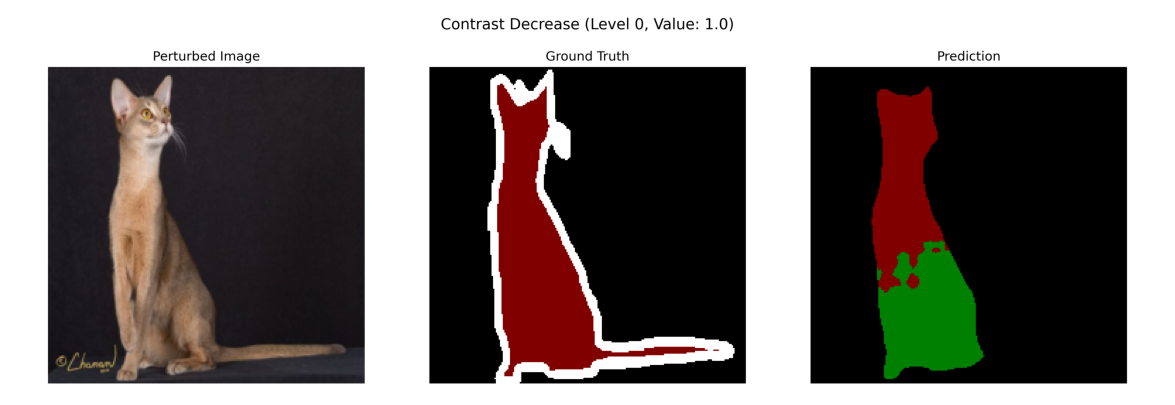

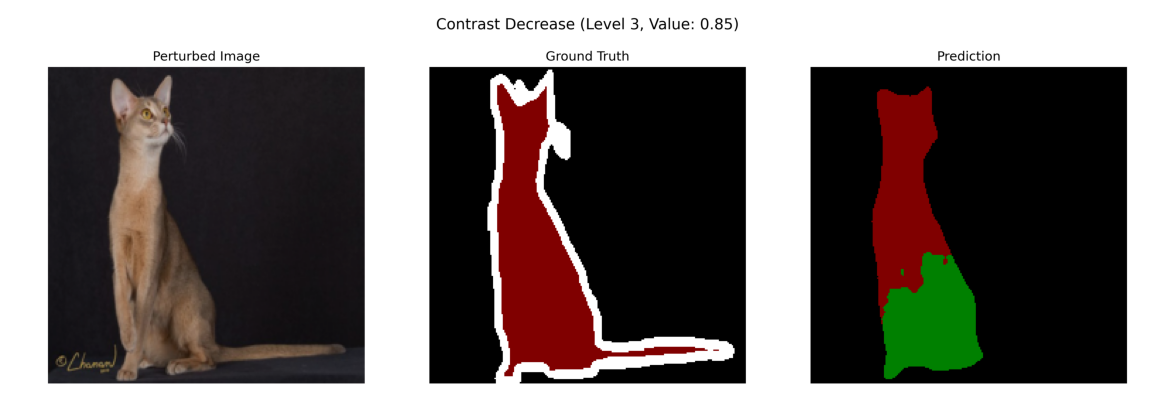

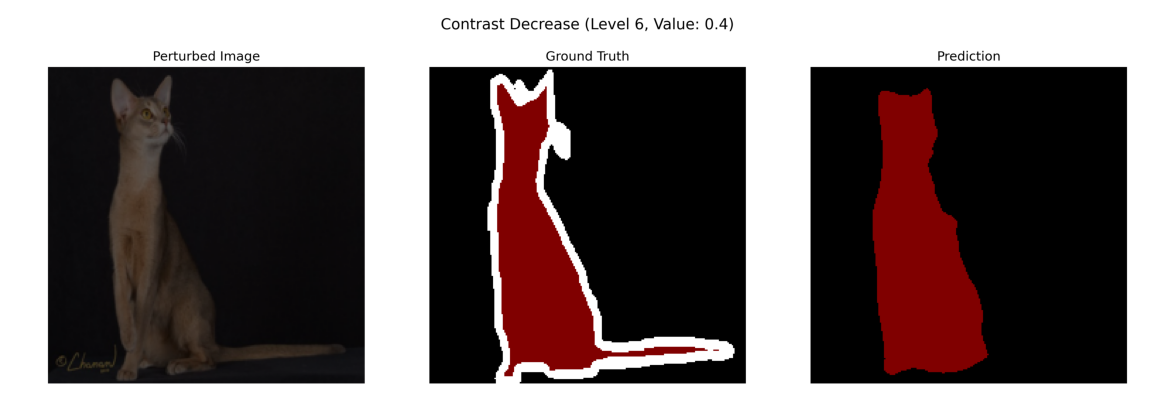

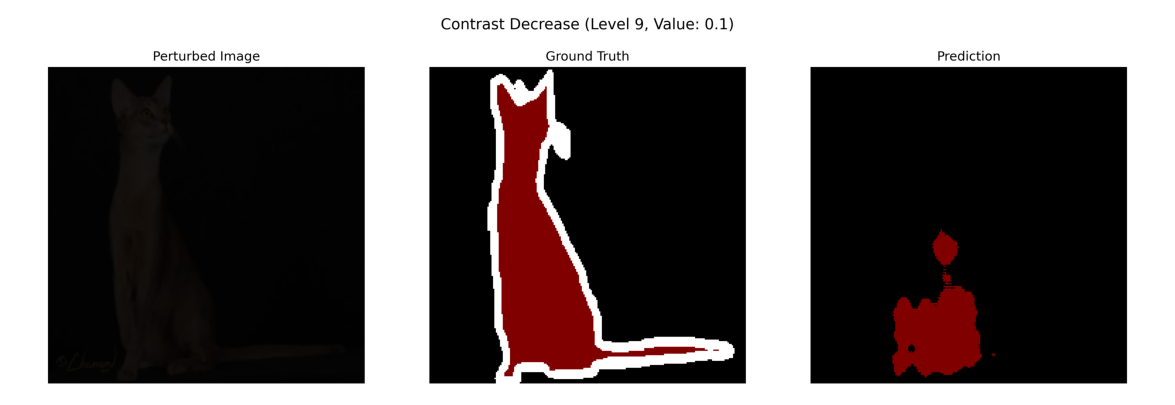

In [11]:
# Select a perturbation to visualize
# Pick the most impactful perturbation based on our analysis above
most_impactful_perturbation = sorted_perturbations[0][0]
print(f"Visualizing predictions for {most_impactful_perturbation} perturbation...")

# Create directory for visualization examples
viz_dir = os.path.join(OUTPUT_DIR, 'predictions')
os.makedirs(viz_dir, exist_ok=True)

# Visualize predictions at different intensity levels
visualize_predictions(
    model, 
    DATASET_ROOT, 
    most_impactful_perturbation, 
    levels=[0, 3, 6, 9],  # Original, mild, medium, and strong perturbation
    device=device,
    output_dir=viz_dir
)

# Display the images
for level in [0, 3, 6, 9]:
    img_path = os.path.join(viz_dir, f"{most_impactful_perturbation}_level_{level}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(15, 5))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.show()

## 10. Visualise Another Important Perturbation

same for the second most impactful perturbation to get a broader understanding.

Visualizing predictions for salt_pepper perturbation...


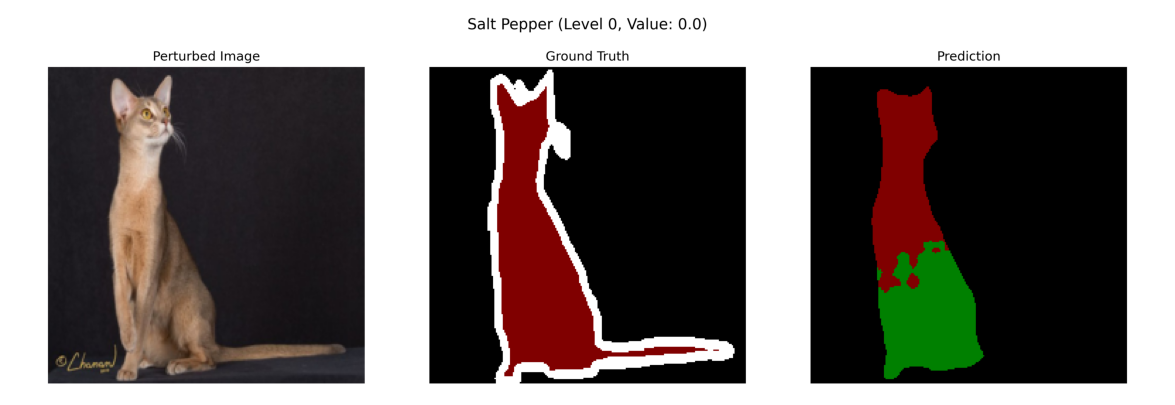

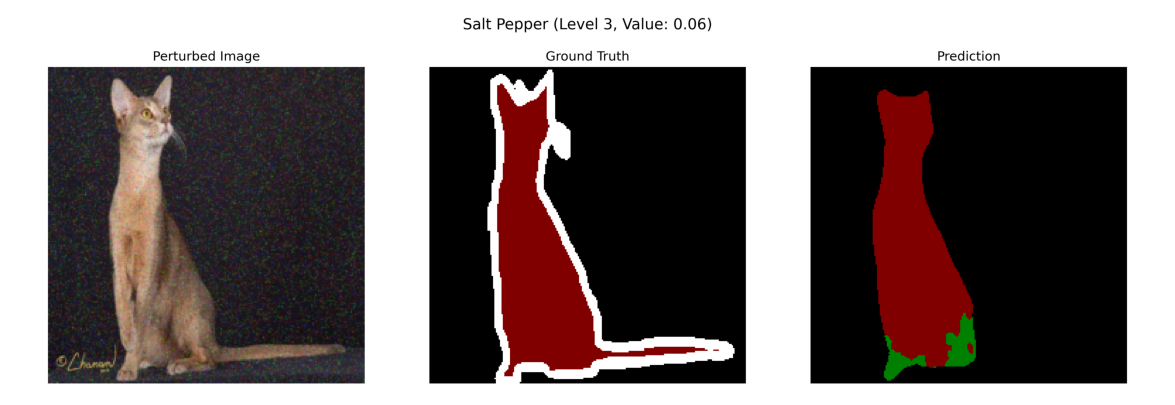

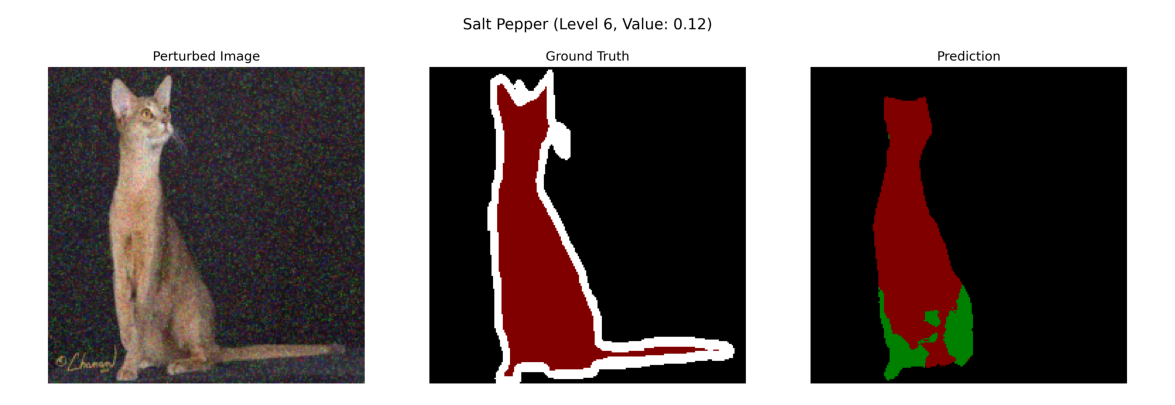

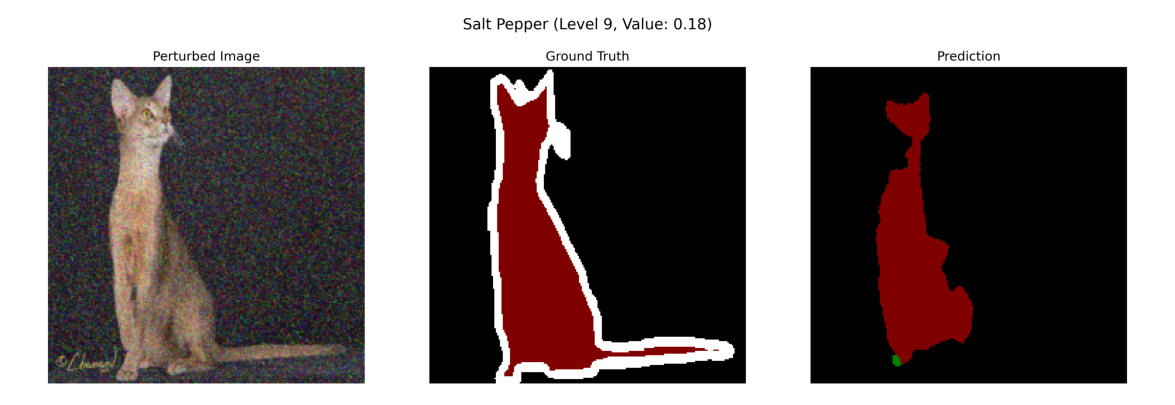

In [12]:
# Select the second most impactful perturbation
second_perturbation = sorted_perturbations[1][0]
print(f"Visualizing predictions for {second_perturbation} perturbation...")

# Visualize predictions at different intensity levels
visualize_predictions(
    model, 
    DATASET_ROOT, 
    second_perturbation, 
    levels=[0, 3, 6, 9],  # Original, mild, medium, and strong perturbation
    device=device,
    output_dir=viz_dir
)

# Display the images
for level in [0, 3, 6, 9]:
    img_path = os.path.join(viz_dir, f"{second_perturbation}_level_{level}.png")
    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(figsize=(15, 5))
        plt.imshow(np.array(img))
        plt.axis('off')
        plt.show()

## 11. Conclusions

In [13]:
# Calculate key statistics for the report
init_scores = {p: scores[0] for p, scores in results.items()}
final_scores = {p: scores[-1] for p, scores in results.items()}
avg_init_score = np.mean(list(init_scores.values()))
avg_final_score = np.mean(list(final_scores.values()))
avg_decrease = (avg_init_score - avg_final_score) / avg_init_score * 100

print("Key Statistics:")
print(f"Average baseline Dice score (no perturbation): {avg_init_score:.4f}")
print(f"Average Dice score at maximum perturbation: {avg_final_score:.4f}")
print(f"Average performance decrease: {avg_decrease:.2f}%")
print("\nMost impactful perturbations:")
for i, (perturbation, decrease) in enumerate(sorted_perturbations[:3]):
    print(f"{i+1}. {perturbation.replace('_', ' ').title()}: {decrease:.2f}% decrease")

print("\nLeast impactful perturbations:")
for i, (perturbation, decrease) in enumerate(sorted_perturbations[-3:]):
    print(f"{i+1}. {perturbation.replace('_', ' ').title()}: {decrease:.2f}% decrease")

Key Statistics:
Average baseline Dice score (no perturbation): 0.6159
Average Dice score at maximum perturbation: 0.5375
Average performance decrease: 12.73%

Most impactful perturbations:
1. Contrast Decrease: 44.66% decrease
2. Salt Pepper: 41.95% decrease
3. Gaussian Blur: 6.75% decrease

Least impactful perturbations:
1. Brightness Increase: 1.20% decrease
2. Occlusion: 1.12% decrease
3. Contrast Increase: 0.31% decrease
